In [97]:
#________________________Import
import os
import pandas as pd
import datetime as dt
from pandas_datareader import data as pdr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import scipy.optimize as sc
import matplotlib.ticker as mtick
import datetime
import yfinance as yf
import matplotlib.ticker as mtick
from sklearn.decomposition import PCA
import copy
import plotly.graph_objects as go


# Import de données
def getData(parameters):
    #stockData = yf.download(stocks, start = start, end = end)
    #stockData = stockData['Close']
    stockData = pd.read_csv("/Users/iliasrazig/Documents/mbf3/Mémoire/sp500.csv", header=[0], index_col=[0], parse_dates= True)
    topsectosp500 = pd.read_excel("/Users/iliasrazig/Documents/mbf3/Mémoire/stocks_list.xlsx")
    stocks = topsectosp500['Ticker Yahoo'].values.tolist()
    stockData = stockData[stocks]
    stockData = stockData.dropna()
    if parameters == 'mean-variance' :
        stockDataparam = stockData.loc[stockData.index <= '2021-12-31']
        stockDataparam = stockDataparam.loc[stockDataparam.index>'2019-12-31']
        returns = stockDataparam.pct_change()
        meanReturns = returns.mean()
        covMatrix = returns.cov()
    elif parameters == 'LSTM' : 
        stockDataparam = stockData.loc[stockData.index <= '2021-12-31']
        stockDataparam = stockDataparam.loc[stockDataparam.index>'2020-12-31']
        returns = stockDataparam.pct_change() 
        meanReturns = []
        for element in stockData.columns.values.tolist() : 
            prediction = pd.read_csv("/Users/iliasrazig/Documents/mbf3/Mémoire/Prédictions/predictions"+ str(element) + ".csv")
            returns_futurs = prediction['Prix predits']
            extremums = prediction[(prediction['Date'] >= '2022-01-01') & (prediction['Date'] <= '2023-07-31')]
            # valeurs de début et de fin
            P0 = extremums.iloc[0]['Prix predits']
            Pn = extremums.iloc[-1]['Prix predits']
            # Calculez le nombre total de jours entre les deux dates
            n = len(returns_futurs)
            # taux de croissance 
            GR = (Pn / P0) - 1
        
            #returns_futurs = returns_futurs.pct_change() 
            meanReturns.append(GR)

            #prediction = prediction['Prix predits'].values.tolist()
            #debut = prediction[0]
            #fin = prediction[len(prediction)-1]
            #taux_croissance = (debut/fin)-1
            #meanReturns.append(float(taux_croissance))
            covMatrix = returns.cov()
        meanReturns = pd.Series(meanReturns, index= stockData.columns)
            
    stockData = stockData.loc[stockData.index>'2021-12-31']
    return meanReturns, covMatrix, stockData



def portfolioPerformance(weights, meanReturns, covMatrix):
    returns = np.sum(meanReturns*weights)
    std = np.sqrt(
            np.dot(weights.T,np.dot(covMatrix, weights))
           )*np.sqrt(252)
    return returns, std



def negativeSR(weights, meanReturns, covMatrix, riskFreeRate = 0):
    pReturns, pStd = portfolioPerformance(weights, meanReturns, covMatrix)
    return - (pReturns - riskFreeRate)/pStd
def maxSR(meanReturns, covMatrix, riskFreeRate = 0, constraintSet=(0,1)):
    "Minimize the negative SR, by altering the weights of the portfolio"
    numAssets = len(meanReturns)
    args = (meanReturns, covMatrix, riskFreeRate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = constraintSet
    bounds = tuple(bound for asset in range(numAssets))
    result = sc.minimize(negativeSR, numAssets*[1./numAssets], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result




def portfolioVariance(weights, meanReturns, covMatrix):
    return portfolioPerformance(weights, meanReturns, covMatrix)[1]
def minimizeVariance(meanReturns, covMatrix, constraintSet=(0,1)):
    """Minimize the portfolio variance by altering the 
     weights/allocation of assets in the portfolio"""
    numAssets = len(meanReturns)
    args = (meanReturns, covMatrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = constraintSet
    bounds = tuple(bound for asset in range(numAssets))
    result = sc.minimize(portfolioVariance, numAssets*[1./numAssets], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result




def portfolioReturn(weights, meanReturns, covMatrix):
        return portfolioPerformance(weights, meanReturns, covMatrix)[0]

def minimizereturns(meanReturns, covMatrix, constraintSet=(0,1)):
    """Minimize the portfolio retunr by altering the 
     weights/allocation of assets in the portfolio"""
    numAssets = len(meanReturns)
    args = (meanReturns, covMatrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = constraintSet
    bounds = tuple(bound for asset in range(numAssets))
    result = sc.minimize(portfolioReturn, numAssets*[1./numAssets], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

def efficientOpt(meanReturns, covMatrix, returnTarget, constraintSet=(0,1)):
    """For each returnTarget, we want to optimise the portfolio for min variance"""
    numAssets = len(meanReturns)
    args = (meanReturns, covMatrix)
    constraints = ({'type':'eq', 'fun': lambda x: portfolioReturn(x, meanReturns, covMatrix) - returnTarget},
                    {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = constraintSet
    bounds = tuple(bound for asset in range(numAssets))
    effOpt = sc.minimize(portfolioVariance, numAssets*[1./numAssets], args=args, method = 'SLSQP', bounds=bounds, constraints=constraints)
    return effOpt


def calculatedResults(meanReturns, covMatrix, riskFreeRate=0, constraintSet=(0,1)):
    """Read in mean, cov matrix, and other financial information
        Output, Max SR , Min Volatility, efficient frontier """
    # Max Sharpe Ratio Portfolio
    maxSR_Portfolio = maxSR(meanReturns, covMatrix)
    maxSR_returns, maxSR_std = portfolioPerformance(maxSR_Portfolio['x'], meanReturns, covMatrix)
    maxSR_returns, maxSR_std = round(maxSR_returns*100,2), round(maxSR_std*100,2)
    maxSR_allocation = pd.DataFrame(maxSR_Portfolio['x'], index=meanReturns.index, columns=['allocation'])
    maxSR_allocation.allocation = [i*100 for i in maxSR_allocation.allocation]
    
    # Min Volatility Portfolio
    minVol_Portfolio = minimizeVariance(meanReturns, covMatrix)
    minVol_returns, minVol_std = portfolioPerformance(minVol_Portfolio['x'], meanReturns, covMatrix)
    minVol_returns, minVol_std = round(minVol_returns*100,2), round(minVol_std*100,2)
    minVol_allocation = pd.DataFrame(minVol_Portfolio['x'], index=meanReturns.index, columns=['allocation'])
    minVol_allocation.allocation = [i*100 for i in minVol_allocation.allocation]

    # Min return Portfolio
    minRet_Portfolio = minimizereturns(meanReturns, covMatrix)
    minRet_returns, minRet_std = portfolioPerformance(minRet_Portfolio['x'], meanReturns, covMatrix)
    minRet_returns, minRet_std = round(minRet_returns*100,2), round(minRet_std*100,2)
    minRet_allocation = pd.DataFrame(minRet_Portfolio['x'], index=meanReturns.index, columns=['allocation'])
    minRet_allocation.allocation = [i*100 for i in minRet_allocation.allocation]

    # Efficient Frontier
    efficientList = []
    targetReturns = np.linspace(minRet_returns, maxSR_returns, 30)/100
    for target in targetReturns:
        efficientList.append(efficientOpt(meanReturns, covMatrix, target)['fun'])
    return maxSR_returns, maxSR_std, maxSR_allocation, minVol_returns, minVol_std, minVol_allocation, minRet_returns, minRet_std, minRet_allocation, efficientList, targetReturns

def random_portfolios (n_samples, meanReturns, CovMatrix) :
    w = np.random.dirichlet(np.ones(len(meanReturns))*0.1, size=n_samples)
    w /= np.sum(w, axis=1, keepdims=True)
    rets = np.dot(w, meanReturns)
    stds = np.sqrt(np.diag(np.dot(w.dot(CovMatrix), w.T)))*np.sqrt(252)
    sharpes = rets / stds
    return rets, stds



def EF_graph(meanReturns, covMatrix, riskFreeRate=0, constraintSet=(0,1)):
    """Return a graph ploting the min vol, max sr and efficient frontier"""
    maxSR_returns, maxSR_std, maxSR_allocation, minVol_returns, minVol_std, minVol_allocation, minRet_returns, minRet_std, minRet_allocation, efficientList, targetReturns = calculatedResults(meanReturns, covMatrix, riskFreeRate, constraintSet)
    rets, stds = random_portfolios (100, meanReturns, CovMatrix)
    #Max SR
    MaxSharpeRatio = go.Scatter(
        name='Maximium Sharpe Ratio',
        mode='markers',
        x=[maxSR_std],
        y=[maxSR_returns],
        marker=dict(color='red',size=14,line=dict(width=3, color='black'))
    )
    #Min Vol
    MinVol = go.Scatter(
        name='Mininium Volatility',
        mode='markers',
        x=[minVol_std],
        y=[minVol_returns],
        marker=dict(color='green',size=14,line=dict(width=3, color='black'))
    )
        #Min Return
    MinRet = go.Scatter(
        name='Mininium Return',
        mode='markers',
        x=[minRet_std],
        y=[minRet_returns],
        marker=dict(color='Blue',size=14,line=dict(width=3, color='black'))
    )


        #Efficient Frontier
    EF_curve = go.Scatter(
        name='Frontière Efficiente',
        mode='lines',
        x=[round(ef_std*100, 2) for ef_std in efficientList],
        y=[round(target*100, 2) for target in targetReturns],
        line=dict(color='black', width=4, dash='dashdot')
    )
    #Random portfolios
    portfolios = go.Scatter(
        name='Portefeuilles',
        mode='markers',
        x=[std*100 for std in stds],
        y=[ret*100 for ret in rets],
        marker=dict(color = 'MediumPurple', size=4)
    )
    
    data = [MaxSharpeRatio, MinVol, portfolios, EF_curve]
    layout = go.Layout(
        title = 'Optimisation de portefeuille avec la Frontière Efficiente',
        yaxis = dict(title='Rendement annualisé (%)'),
        xaxis = dict(title=' Volatilité annualisée (%)'),
        showlegend = True,
        legend = dict(
            x = 0.75, y = 0, traceorder='normal',
            bgcolor='#E2E2E2',
            bordercolor='black',
            borderwidth=2),
        width=1200,
        height=900)
    
    fig = go.Figure(data=data, layout=layout)
    
    return fig, maxSR_allocation, minVol_allocation

In [56]:

meanReturns, CovMatrix, data = getData(parameters= 'mean-variance')


In [98]:
meanReturns, CovMatrix, data = getData(parameters= 'LSTM')

In [114]:
pd.DataFrame(round(meanReturns*100,2), columns=['Rendement prédit (en %)'])

,Rendement prédit (en %)
AAPL,8.78
MSFT,-0.33
UNH,0.10
JNJ,-0.57
BRK-B,15.88
JPM,-2.12
AMZN,-20.03
HD,-18.64
RTX,-0.13
HON,-6.48


In [99]:
graph, maxSR, minvol = EF_graph(meanReturns, CovMatrix)
graph

In [101]:
portefeuilles_optimaux = pd.merge(minvol, maxSR, suffixes= ('_minvol', '_maxSharpe_Ratio'), left_index=True, right_index=True)
portefeuilles_optimaux.to_csv("Portefeuilles optimaux de Markowitz avec ML.csv")

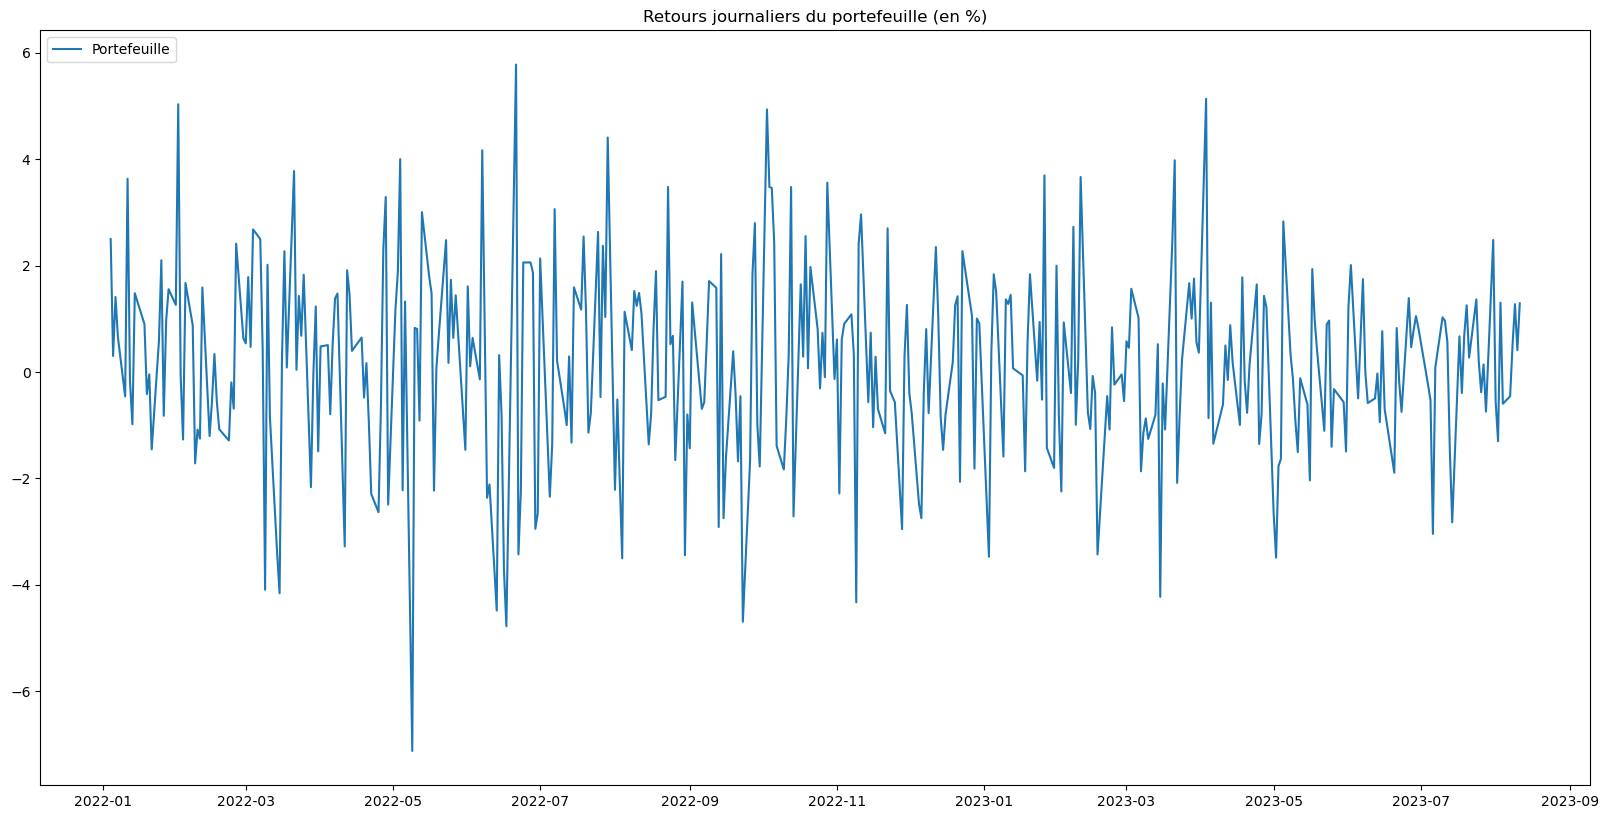

In [102]:
def daily_returns (df, allocation):

#Si des poids son définis 
    try :
        weights = allocation['allocation'].tolist()
        # on multiplie les prix par les poids pour avoir une valeur unvestie par action
        df_portfolio_prices_weighted = df*weights
        # Forward filling et before filling appliqués pour gérer les trous 
        df_portfolio_prices_weighted = df_portfolio_prices_weighted.fillna(method="ffill")
        df_portfolio_prices_weighted = df_portfolio_prices_weighted.fillna(method="bfill")
        # On somme le montant engagé dans chaque action pour avoir la valeur liquidative du portefeuille
        df_portfolio_daily_value = df_portfolio_prices_weighted.sum(axis=1)
        # retours entre 2 jours 
        df_portfolio_daily_returns= (df_portfolio_daily_value/df_portfolio_daily_value.shift(1) -1)*100
    except :
        # dans le cas d'un benchmark on utilise uniquement les prix entre 2 jours
        df = df.fillna(method="ffill")
        df = df.fillna(method="bfill")
        df_portfolio_daily_value = df.sum(axis=1)
        df_portfolio_daily_returns= (df_portfolio_daily_value/df_portfolio_daily_value.shift(1) -1)*100
    return df_portfolio_daily_returns

#retours journaliers de la stratégie 
df_portfolio_daily_returns = daily_returns (df = data, allocation = maxSR)


df_portfolio_daily_returns.to_csv("Retours journaliers du portefeuille optimisé Ratio de Sharpe maximum avec ML.csv")

plt.figure(figsize=(20,10), dpi=100)

# Création du graphique de comparaison des rendements journaliers
plt.plot(df_portfolio_daily_returns, label= "Portefeuille")
plt.legend(loc="upper left")
plt.title("Retours journaliers du portefeuille (en %)")
plt.show()

Date
2022-01-03           NaN
2022-01-04    102.499628
2022-01-05    102.807742
2022-01-06    104.256475
2022-01-07    104.940175
                 ...    
2023-08-07    151.042458
2023-08-08    151.798286
2023-08-09    153.734096
2023-08-10    154.364060
2023-08-11    156.355452
Length: 404, dtype: float64


Text(0.5, 1.0, 'Valorisation du portefeuille')

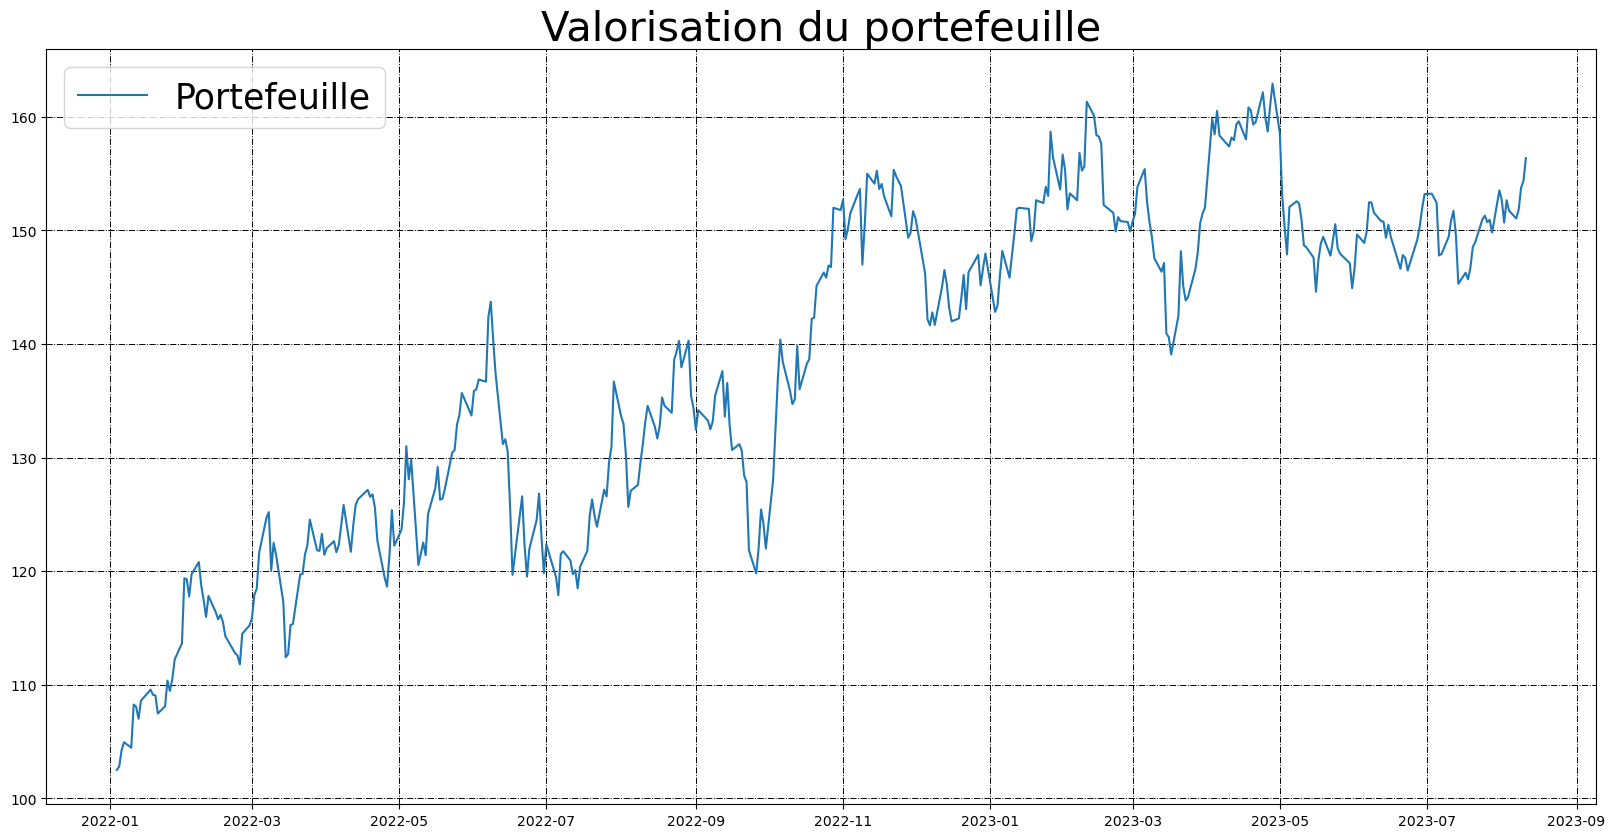

In [103]:
# comparaison de la performance de la stratégie contre l'indice de référence (S&P 500)
start_value = 100

# Calcul de la somme cumulée des retours journaliers
cumulative_returns=((df_portfolio_daily_returns/100)+1).cumprod()*start_value

# Ajout de la valeur cumulée au dataframe
df_portfolio_total_value = cumulative_returns
print(df_portfolio_total_value)
cumulative_returns.to_csv("Valorisation du portefeuille optimisé Ratio de Sharpe maximum avec ML.csv")
                
# Graphique 
plt.figure(figsize=(20,10), dpi=100)
plt.grid(color='black', linestyle='-.', linewidth=0.7) 
plt.plot(df_portfolio_total_value, label= "Portefeuille")
plt.legend(loc = "upper left", fontsize=25)
plt.title("Valorisation du portefeuille", fontsize=30)

In [100]:
round(maxSR)

,allocation
AAPL,10.0
MSFT,0.0
UNH,0.0
JNJ,0.0
BRK-B,0.0
JPM,0.0
AMZN,0.0
HD,0.0
RTX,0.0
HON,0.0


In [ ]:
minvol